# Image Understanding using SegmentNet
Attempt to encode a black & white image using segmentNet

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
# load demo image and convert it to grayscale and BW image
from PIL import Image

# Load the image
image = Image.open("demo.jpg")

np.array(image).shape

(427, 640, 3)

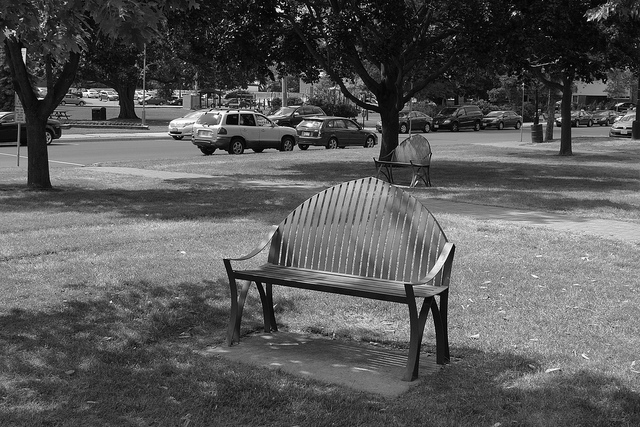

In [4]:
# Convert the image to grayscale
grayscale_image = image.convert("L")

# Save the grayscale image (optional)
#grayscale_image.save("grayscale.jpg")

# Display the grayscale image
display(grayscale_image)

In [5]:
# Get the image data as a NumPy array
grayscale_array = np.array(grayscale_image)

# Optionally, check the dimensions and data type
print(f"Shape of the NumPy array: {grayscale_array.shape}")
print(f"Data type of the NumPy array: {grayscale_array.dtype}")

Shape of the NumPy array: (427, 640)
Data type of the NumPy array: uint8


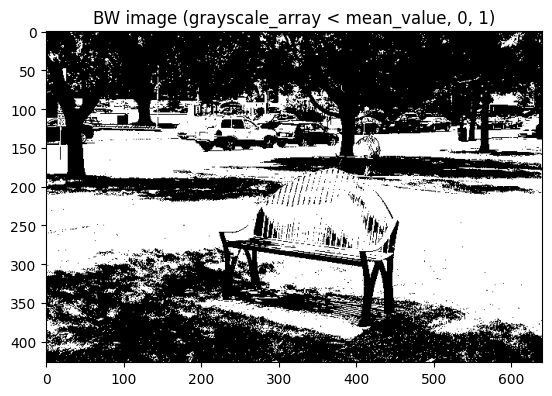

427 640


In [6]:
#convert to BW image around its mean
mean_value = np.mean(grayscale_array)

bw_array  = torch.tensor(np.where(grayscale_array < mean_value, 0, 1))

#Change the shape to HxWxChannel (1 channel)
bw_array = bw_array.unsqueeze(-1)
#Visualize it
plt.imshow(bw_array, cmap="gray")
plt.title("BW image (grayscale_array < mean_value, 0, 1)")
plt.show()
image_height = bw_array.shape[0]
image_width = bw_array.shape[1]
print(image_height, image_width)

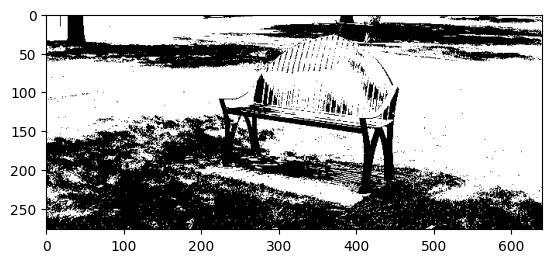

In [7]:
# We can start chopping image from the top
plt.imshow(bw_array[150:,:,0], cmap="gray")

In [8]:
# Return x,y coordinates from a bw_array
def bwarray_to_xy(bw_array, step):
    # torch.min(array, dim=0) will give us lowest location for zero/black value (from the top)
    # zeros_indices is the y value we train the segments on.
    image_height = bw_array.shape[0]
    image_width = bw_array.shape[1]
    rows = torch.arange(0, image_height, step).shape[0]
    cols = image_width
    ys = torch.zeros([rows,cols])
    for i in torch.arange(rows):
        _, zeros_indices = torch.min(bw_array[i*step:,:,0], dim=0)
        mask = zeros_indices > 0
        ys[i] = zeros_indices + zeros_indices.masked_fill(mask, i*step) 
    
    #flip the y axis before we return y
    y = image_height - ys
    x = torch.arange(0,image_width)
    return x, y

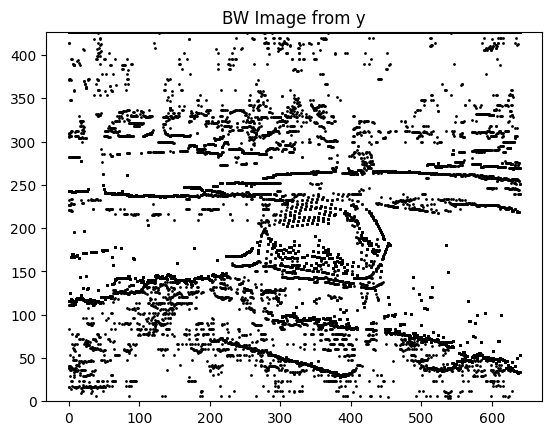

In [9]:
# Get x,y from BW image
step = 6
x, y = bwarray_to_xy(bw_array, step)

# Plot the y,x coordinates to confirm they represent image
plt.ylim(ymin=0, ymax=image_height)
plt.title("BW Image from y")
for i in torch.arange(y.shape[0]):
    plt.scatter(x, y[i] ,s=1,c='black')

## Making simple image by drawing

In [10]:
# draw a circle
from PIL import Image, ImageDraw

width, height = 640, 480
image = Image.new("RGB", (width, height), "white")  # Black background
draw = ImageDraw.Draw(image)

In [11]:
# Coordinates of the circle center
center_x, center_y = 420, 140  # Adjust these to your desired position

# Radius of the circle
radius = 100  # Adjust this to your desired size

# Color (black in this case)
color = (0, 0, 0)  # White for black & white
draw.ellipse((center_x - radius, center_y - radius, center_x + radius, center_y + radius), fill=None, outline=color, width=4)


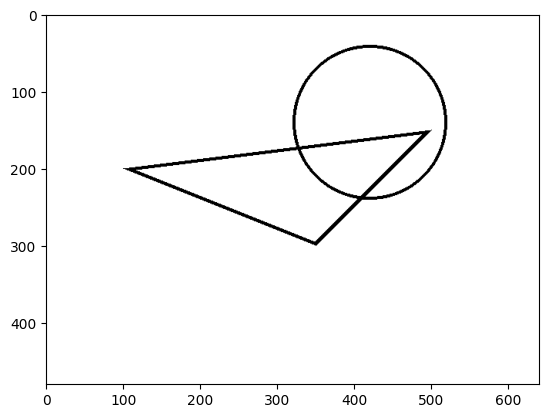

In [12]:
# Add a triangle
# Define the coordinates of three points (vertices) for the triangle
# Adjust these values to change the triangle's size and position
point1 = (100, 200)
point2 = (350, 300)
point3 = (500, 150)

# Alternatively, you can create a list of all points
points = [point1, point2, point3]
draw.polygon(points, fill=None, outline=color, width=5)

plt.imshow(image)

## Try grayscale image by creating two more images .5 and 1.5x mean image

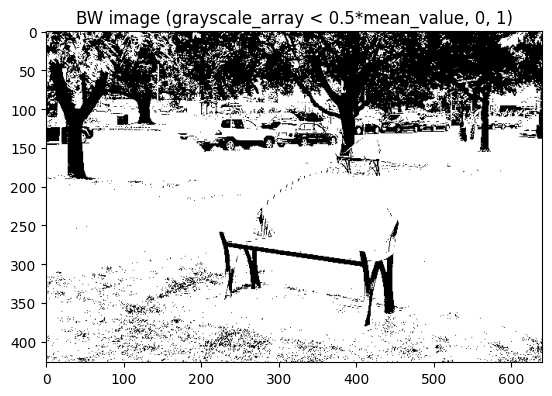

In [13]:
#convert to BW image around its mean
mean_value = np.mean(grayscale_array)

bw_array_1  = torch.tensor(np.where(grayscale_array < 0.5*mean_value, 0, 1))

#Change the shape to HxWxChannel (1 channel)
bw_array_1 = bw_array_1.unsqueeze(-1)
#Visualize it
plt.imshow(bw_array_1, cmap="gray")
plt.title("BW image (grayscale_array < 0.5*mean_value, 0, 1)")
plt.show()

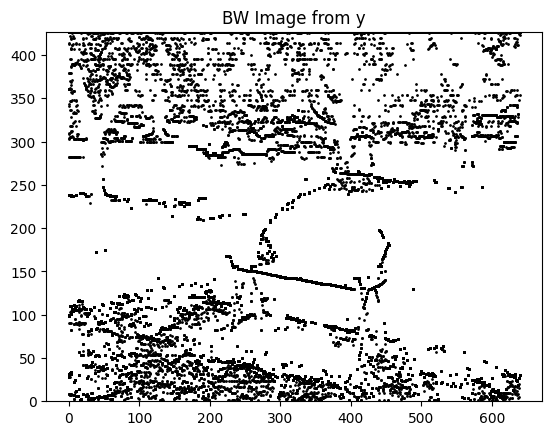

In [14]:
# calculate y and plot
step = 6
x, y = bwarray_to_xy(bw_array_1, step)

# Plot the y,x coordinates to confirm they represent image
plt.ylim(ymin=0, ymax=image_height)
plt.title("BW Image from y")
for i in torch.arange(y.shape[0]):
    plt.scatter(x, y[i] ,s=1,c='black')

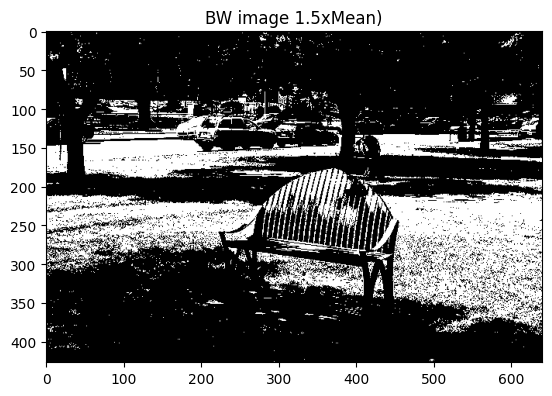

In [15]:
#convert to BW image around its mean
mean_value = np.mean(grayscale_array)

bw_array_2  = torch.tensor(np.where(grayscale_array < 1.5*mean_value, 0, 1))

#Change the shape to HxWxChannel (1 channel)
bw_array_2 = bw_array_2.unsqueeze(-1)
#Visualize it
plt.imshow(bw_array_2, cmap="gray")
plt.title("BW image 1.5xMean)")
plt.show()

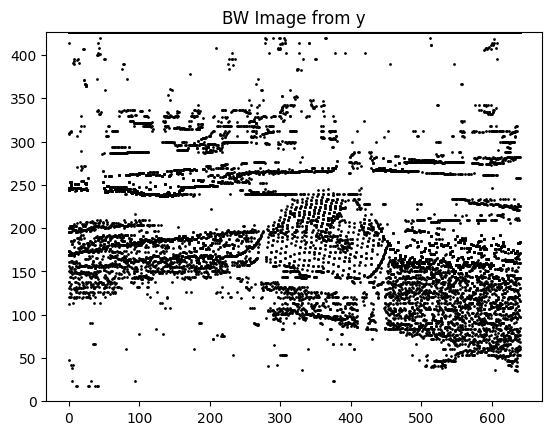

In [16]:
# calculate y and plot
step = 6
x, y = bwarray_to_xy(bw_array_2, step)

# Plot the y,x coordinates to confirm they represent image
plt.ylim(ymin=0, ymax=image_height)
plt.title("BW Image from y")
for i in torch.arange(y.shape[0]):
    plt.scatter(x, y[i] ,s=1,c='black')